# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [12]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [13]:
import sklearn

In [16]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [37]:
# Load experiment metadata (replace 'metadata_file.csv' with the actual file path)
metadata_df = pd.read_csv('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv', delimiter='\t')

# Print the columns in the metadata DataFrame
print("Metadata Columns:", metadata_df.columns)

# Load experiment metadata (replace 'metadata_file.csv' with the actual file path)
metadata_df = pd.read_csv('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv', delimiter='\t')

# Print the columns and the first few rows in the metadata DataFrame
print("Metadata Columns:", metadata_df.columns)
print("\nFirst Few Rows of Metadata:")
print(metadata_df.head())


/var/folders/hp/p8lrjqpd7v35j_mgh8f2h_gc0000gn/T/ipykernel_52245/3043841442.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv', delimiter='\t')


Metadata Columns: Index(['Unnamed: 0', 'File accession', 'File format', 'File type',
       'File format type', 'Output type', 'File assembly',
       'Experiment accession', 'Assay', 'Donor(s)', 'Biosample term id',
       'Biosample term name', 'Biosample type', 'Biosample organism',
       'Biosample treatments', 'Biosample treatments amount',
       'Biosample treatments duration',
       'Biosample genetic modifications methods',
       'Biosample genetic modifications categories',
       'Biosample genetic modifications targets',
       'Biosample genetic modifications gene targets',
       'Biosample genetic modifications site coordinates',
       'Biosample genetic modifications zygosity', 'Experiment target',
       'Library made from', 'Library depleted in', 'Library extraction method',
       'Library lysis method', 'Library crosslinking method',
       'Library strand specific', 'Experiment date released', 'Project',
       'RBNS protein concentration', 'Library fragmentati

/var/folders/hp/p8lrjqpd7v35j_mgh8f2h_gc0000gn/T/ipykernel_52245/3043841442.py:8: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv', delimiter='\t')


In [17]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/hp/p8lrjqpd7v35j_mgh8f2h_gc0000gn/T/ipykernel_52245/4202323214.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv')


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


/var/folders/hp/p8lrjqpd7v35j_mgh8f2h_gc0000gn/T/ipykernel_52245/1277939184.py:8: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv')


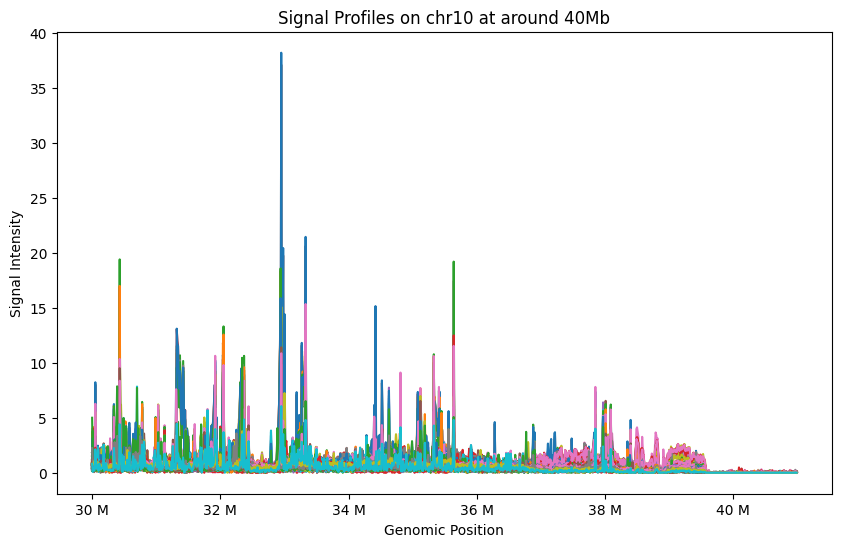

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

# Load data
df = pd.read_table('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_binned_subset.tsv')
bigwig_metadata = pd.read_table('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv')

# Extract relevant columns
chrom_col = df['chrom']
start_col = df['start']
end_col = df['end']
signal_cols = df.columns[3:]  # Assuming signal columns start from the 4th column

# Select data for chr10 at around 40Mb
chr10_40Mb_data = df[(chrom_col == 'chr10') & (start_col >= 30000000) & (end_col <= 41000000)]

# Visualize profiles
fig, ax = plt.subplots(figsize=(10, 6))
for signal_col in signal_cols:
    ax.plot(chr10_40Mb_data['start'], chr10_40Mb_data[signal_col], label=signal_col)

# Format plot
ax.set_title('Signal Profiles on chr10 at around 40Mb')
ax.set_xlabel('Genomic Position')
ax.set_ylabel('Signal Intensity')
#ax.legend()
ax.xaxis.set_major_formatter(EngFormatter())  # Format x-axis ticks

# Show the plot
plt.show()


- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


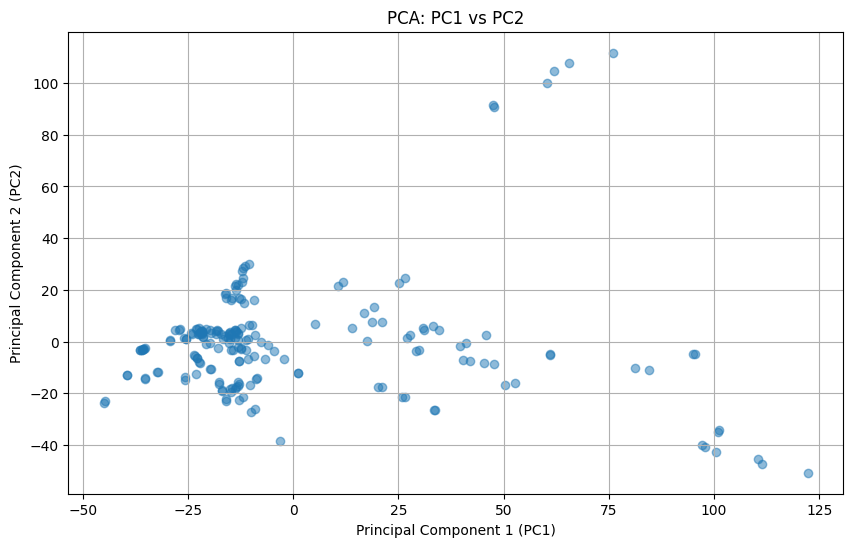

In [22]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load data
df = pd.read_table('/Users/tomasmanea/desktop/qbio577/qbio577_fall2023/data/ENCODE_GRCh38_binned_subset.tsv')

# Extract relevant columns
signal_cols = df.columns[3:]  # Assuming signal columns start from the 4th column

# Extract feature data (excluding chrom, start, end columns)
feature_data = df[signal_cols].values

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(feature_data)

# Create DataFrame with PC1 and PC2 values
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualize PC1 vs PC2 in a scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(pc_df['PC1'], pc_df['PC2'], alpha=0.5)
plt.title('PCA: PC1 vs PC2')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True)
plt.show()


- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

/var/folders/hp/p8lrjqpd7v35j_mgh8f2h_gc0000gn/T/ipykernel_52245/2871284641.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


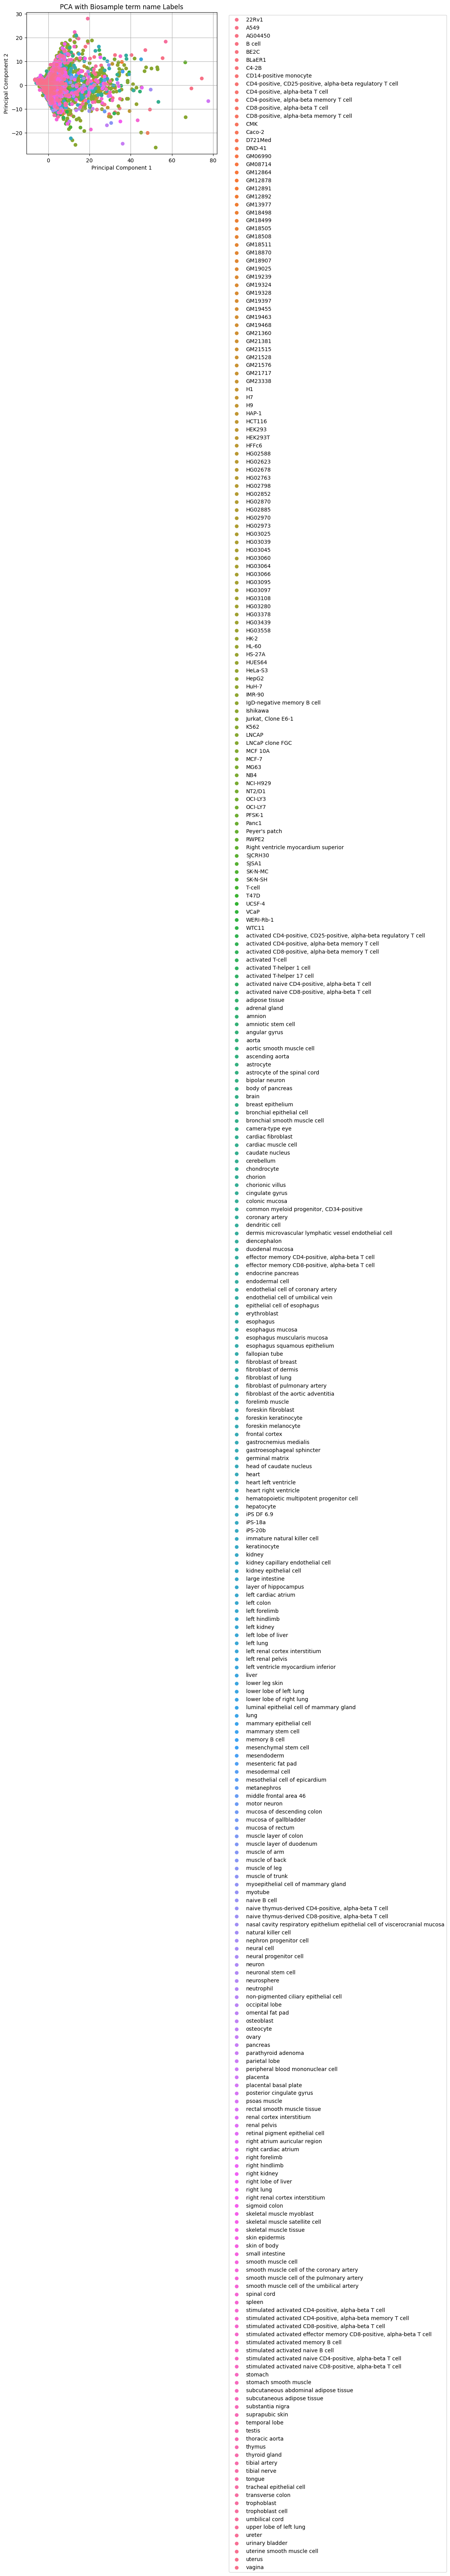

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

def visualize_pca_for_column(df, metadata_df, column_name):
    if column_name in metadata_df.columns:
        # Select the same rows from metadata_df as in df
        aligned_subset = metadata_df.loc[df.index, column_name]

        le = LabelEncoder()
        labels = le.fit_transform(aligned_subset)
        # Unique labels and their names
        unique_labels = np.unique(labels)
        label_names = le.inverse_transform(unique_labels)

        # Get a palette with as many colors as unique labels
        palette = sns.color_palette("husl", len(unique_labels))

        # Scatter plot for each category
        for i, (label, color) in enumerate(zip(label_names, palette)):
            subset = df[labels == i]
            plt.scatter(subset['PC1'], subset['PC2'], c=[color], label=label)

        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'PCA with {column_name} Labels')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'{column_name}' column not found in the metadata.")

# Usage example
# Assuming you have loaded your dataframes df and metadata_df
visualize_pca_for_column(pc_df, metadata_df, 'Biosample term name')


- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


There appear to be consistencies in specific groups within the experimental targets, which require further analysis: T-cells, mesodermal cells, and right-side/skeletal cells (e.g. blue, violet, salmon, respectively). This follows a similar silhouttee as the patterns seen in PCA, however, these are ambigious readings in relation to the broad nature of the Assays. 

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


Index(['Unnamed: 0', 'File accession', 'File format', 'File type',
       'File format type', 'Output type', 'File assembly',
       'Experiment accession', 'Assay', 'Donor(s)', 'Biosample term id',
       'Biosample term name', 'Biosample type', 'Biosample organism',
       'Biosample treatments', 'Biosample treatments amount',
       'Biosample treatments duration',
       'Biosample genetic modifications methods',
       'Biosample genetic modifications categories',
       'Biosample genetic modifications targets',
       'Biosample genetic modifications gene targets',
       'Biosample genetic modifications site coordinates',
       'Biosample genetic modifications zygosity', 'Experiment target',
       'Library made from', 'Library depleted in', 'Library extraction method',
       'Library lysis method', 'Library crosslinking method',
       'Library strand specific', 'Experiment date released', 'Project',
       'RBNS protein concentration', 'Library fragmentation method',
      

/var/folders/hp/p8lrjqpd7v35j_mgh8f2h_gc0000gn/T/ipykernel_52245/1154653718.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


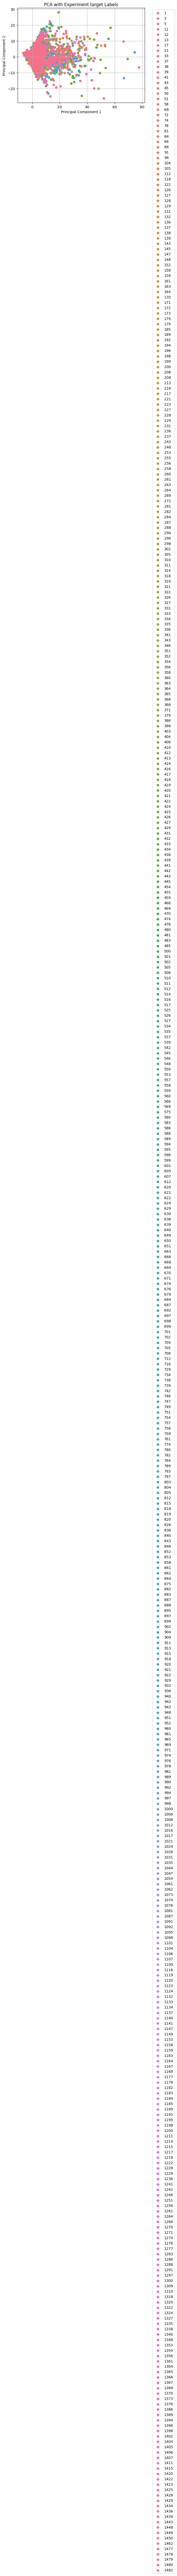

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

#print(metadata_df.columns)

def visualize_pca_for_column_with_targets(df, metadata_df, target_column):
    if target_column in metadata_df.columns:
        # Select the same rows from metadata_df as in df
        aligned_subset = metadata_df.loc[df.index, target_column]

        le = LabelEncoder()
        labels = le.fit_transform(aligned_subset)
        unique_labels = np.unique(labels)
        label_names = le.inverse_transform(unique_labels)

        palette = sns.color_palette("husl", len(unique_labels))

        for i, (label, color) in enumerate(zip(label_names, palette)):
            subset = df[labels == i]
            plt.scatter(subset['PC1'], subset['PC2'], c=[color], label=label)

        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'PCA with {target_column} Labels')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'{target_column}' column not found in the metadata.")

# Usage example
# Assuming you have loaded your dataframes pc_df and metadata_df
visualize_pca_for_column_with_targets(pc_df, metadata_df, 'Experiment target')


There are some proximities that appear quite interesting—as mentioned above, but in particular the pink array appears far more ubiquitous/central to the results. Unfortunately, the names did not load on the key. 

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


Preprocessing—in this scenerio—doesn't largely impact the trends present in the original PCA analysis; if anything the preprocessing, preprocessing further clarifies trends that might otherwise be muddled when we include the entirety of the points. However, for the sake of scientific communication, the original graph serves as a better reference point, since it provides more nuance by-way of outliers. 

/var/folders/hp/p8lrjqpd7v35j_mgh8f2h_gc0000gn/T/ipykernel_52245/93041543.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


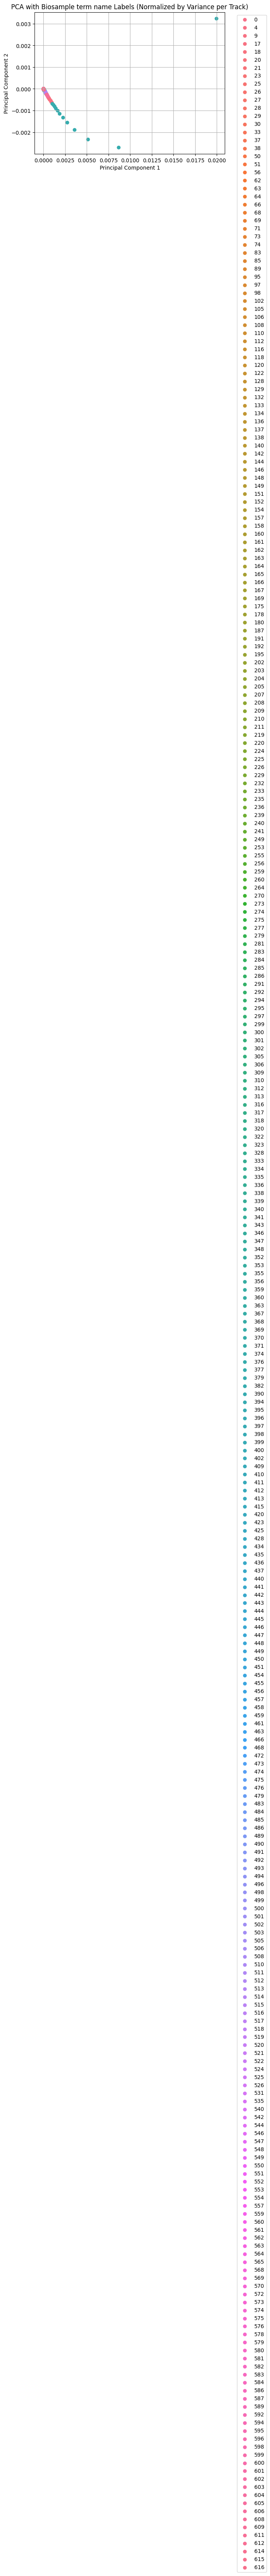

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

def normalize_by_variance_per_track(data):
    # Assuming data is a DataFrame where rows are samples and columns are features
    return data.divide(data.var(axis=1), axis=0)

def visualize_pca_for_column(df, metadata_df, column_name):
    # Select the same rows from metadata_df as in df
    aligned_subset = metadata_df.loc[df.index, column_name]

    le = LabelEncoder()
    labels = le.fit_transform(aligned_subset)
    # Unique labels and their names
    unique_labels = np.unique(labels)
    label_names = le.inverse_transform(unique_labels)

    # Exclude non-numeric columns (e.g., 'chrom')
    numeric_df = df.select_dtypes(include=[np.number])

    # Normalize by variance per track
    normalized_data = normalize_by_variance_per_track(numeric_df)

    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(normalized_data)

    # Create DataFrame with PC1 and PC2 values
    pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    # Get a palette with as many colors as unique labels
    palette = sns.color_palette("husl", len(unique_labels))

    # Scatter plot for each category
    for i, (label, color) in enumerate(zip(label_names, palette)):
        subset = pc_df[labels == i]
        plt.scatter(subset['PC1'], subset['PC2'], c=[color], label=label)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA with {column_name} Labels (Normalized by Variance per Track)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage example
# Assuming you have loaded your dataframes df and metadata_df
visualize_pca_for_column(df, metadata_df, 'Biosample term name')


- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


The answer says 1, however, I strongly believe that this is not the case. 

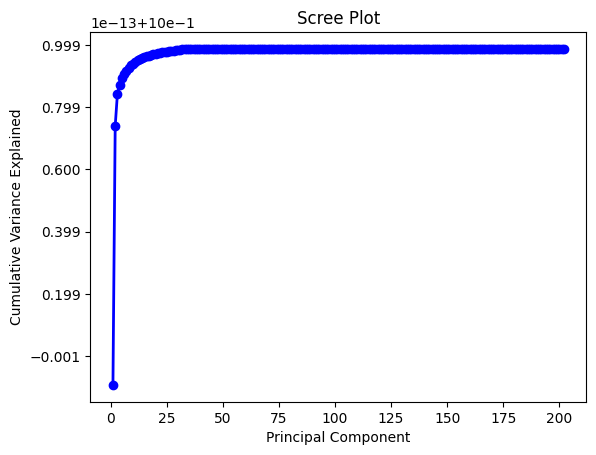

Number of components needed to explain at least 90% of the variance: 1


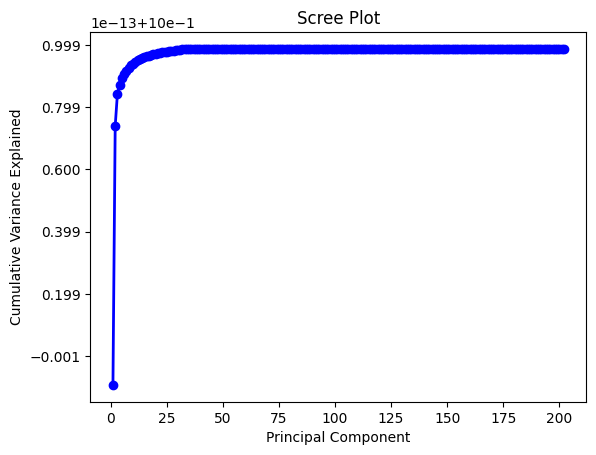

Number of components needed to explain at least 90% of the variance: 1


In [97]:
#Original Example

def scree_plot(df):
    # Exclude non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Perform PCA to get explained variance
    pca = PCA()
    pcafit = pca.fit(numeric_df)

    # Scree plot
    PC_values = np.arange(1, pca.n_components_ + 1)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure()
    plt.plot(PC_values, cumulative_variance, 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Variance Explained')
    plt.show()

    # Find number of components needed to explain at least 90% variance
    num_components = np.argmax(cumulative_variance >= 0.9) + 1
    print(f"Number of components needed to explain at least 90% of the variance: {num_components}")

# Usage example
# Assuming you have loaded your dataframe df
scree_plot(df)

##Iterative Example, utilizing iteration over the cumulative variance to find the first index when 90% is reached or exceeded

def scree_plot(df):
    # Exclude non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Perform PCA to get explained variance
    pca = PCA()
    pcafit = pca.fit(numeric_df)

    # Scree plot
    PC_values = np.arange(1, pca.n_components_ + 1)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.figure()
    plt.plot(PC_values, cumulative_variance, 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Variance Explained')
    plt.show()

    # Find number of components needed to explain at least 90% variance
    num_components = 0
    cumulative_explained_variance = 0
    while cumulative_explained_variance < 0.9 and num_components < len(PC_values):
        cumulative_explained_variance = cumulative_variance[num_components]
        num_components += 1

    print(f"Number of components needed to explain at least 90% of the variance: {num_components}")

# Usage example
# Assuming you have loaded your dataframe df
scree_plot(df)



- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


/Users/tomasmanea/anaconda3/envs/qbio577/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


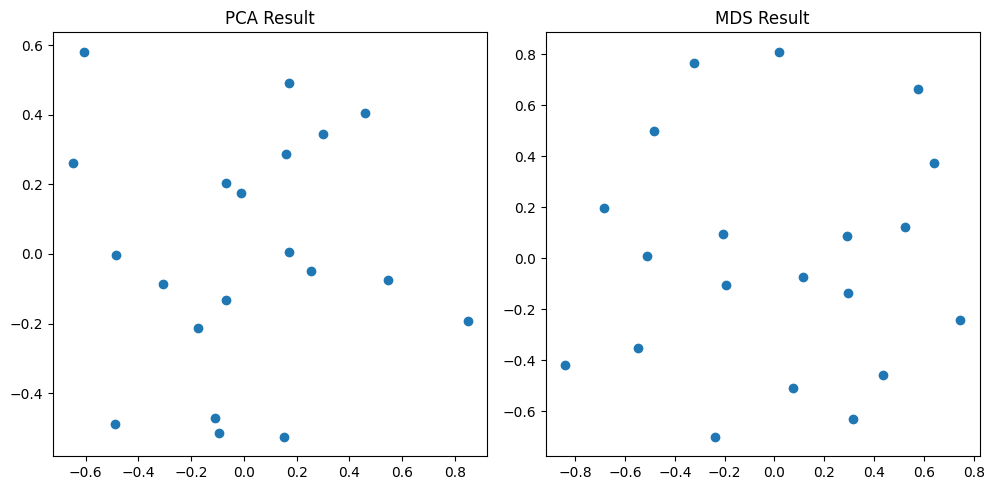

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# Generate sample data
np.random.seed(42)
X = np.random.rand(20, 5)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Perform MDS
mds = MDS(n_components=2)
mds_result = mds.fit_transform(X)

# Plot PCA and MDS results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], label='PCA')
plt.title('PCA Result')

plt.subplot(1, 2, 2)
plt.scatter(mds_result[:, 0], mds_result[:, 1], label='MDS')
plt.title('MDS Result')

plt.tight_layout()
plt.show()


- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


The non-negative matrix factorization would be an interesting method to explore, specifically as its functions are to apply an inherent clustering and the data—after PCA—will have effective dimensionality reduction applied. 